In [13]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
#Load Datasets

## load Project Sunroof Data
sr_data = pd.read_csv("data/project-sunroof-census_tract.csv", index_col="region_name")
sr_data = sr_data.rename_axis(index={"region_name": "GEOID"})
sr_data.index = sr_data.index.astype(int)
#print(sr_data.head(5))

#load Energy Equity Project Data
eep_data = pd.read_csv("data/eep_final_data.csv", index_col="GEOID")
eep_data.index = eep_data.index.astype(int)
#print(eep_data.head(5))

#load Justice40 Data
j40_data = pd.read_csv("data/1.0-communities.csv", index_col="Census tract 2010 ID")
j40_data = j40_data.rename(columns={"Census tract 2010 ID": "GEOID"})
j40_data.index = j40_data.index.astype(int)
#print(j40_data.head(5))

#load Opportunity Zone Data
oz_data = pd.read_csv("data/Opportunity_Zone_ExportTable1.csv", index_col="Tract_Boundaries_ID")
oz_data = oz_data.rename(columns={"Tract_Boundaries_ID": "GEOID"})
oz_data.index = oz_data.index.astype(int)
#print(oz_data.head(5))

/var/folders/67/r87g720s2653g554zdhtz1vh0000gn/T/ipykernel_11230/4072438724.py:15: DtypeWarning: Columns (18,26,70,72,85,131) have mixed types. Specify dtype option on import or set low_memory=False.
  j40_data = pd.read_csv("data/1.0-communities.csv", index_col="Census tract 2010 ID")


                     OID_  Tract_Boundaries_NAME Tract_Boundaries_STATE_NAME   
Tract_Boundaries_ID                                                            
1001020100              1             10010201.0                     Alabama  \
1001020200              2             10010202.0                     Alabama   
1001020300              3             10010203.0                     Alabama   
1001020400              4             10010204.0                     Alabama   
1001020500              5             10010205.0                     Alabama   

                    Tract_Boundaries_ST_ABBREV   
Tract_Boundaries_ID                              
1001020100                                  AL  \
1001020200                                  AL   
1001020300                                  AL   
1001020400                                  AL   
1001020500                                  AL   

                                         Poverty_csv_Geography   
Tract_Boundaries_ID   

In [ ]:
#Check datasets for shape
print(sr_data.shape)
print(eep_data.shape)
print(j40_data.shape)
print(sr_geodata.shape) #Missing about 10,000 wHY??
print(eep_geodata.shape)

In [9]:
#Combine data
sr_selected_cols = sr_data[['percent_covered', 'number_of_panels_total', 'number_of_panels_median', 'kw_median', 'kw_total', 
                            'yearly_sunlight_kwh_median', 'yearly_sunlight_kwh_total', 'carbon_offset_metric_tons', 'existing_installs_count']]

eep_selected_cols = eep_data[['STATE_NAME', 'energy_burden', 'num_solar_installers', 'median_income_solar', 'total_pop', 'year_built', 
                              'total_households', 'median_income', 'owner_occupied', 'renter_occupied', 'bipoc_percent', 'community_power_score',  ]]

j40_selected_cols = j40_data[['Total population', 'Is low income?']]

merged_data = pd.merge(sr_selected_cols, eep_selected_cols, left_index=True, right_index=True)
merged_data = pd.merge(merged_data, j40_selected_cols, left_index=True, right_index=True )

print(merged_data.head(5))

            percent_covered  number_of_panels_total  number_of_panels_median   
1001020100       103.360215                 39080.0                     48.0  \
1001020200       104.472843                 59054.0                     44.0   
1001020300       101.278409                 80364.0                     41.0   
1001020400       101.384451                 94598.0                     54.0   
1001020600       113.555195                 93919.0                     48.0   

            kw_median  kw_total  yearly_sunlight_kwh_median   
1001020100      12.00   9770.00                 14854.40286  \
1001020200      11.00  14763.50                 13564.14519   
1001020300      10.25  20091.00                 12725.93064   
1001020400      13.50  23649.50                 16586.32144   
1001020600      12.00  23479.75                 15360.34045   

            yearly_sunlight_kwh_total  carbon_offset_metric_tons   
1001020100                 12300000.0                7325.568357  \
1001

In [11]:
#Clean Data
cleaned_data = merged_data.copy()

#TODO
#EEP energy_burden has 100% values for some tracts
#SR has negative values

TypeError: '<' not supported between instances of 'str' and 'int'

In [49]:
#Very simple MCDA for energy_burden and kw_total

weights = {
    'kw_total': 0.5,
    'energy_burden': 0.5
}

normalized_data = merged_data.copy()

#minmax normalization
for criterion in weights.keys():
    normalized_data[criterion] = normalized_data[criterion] / normalized_data[criterion].max()

#z-score normalization (this assumes the datasets have normal distributions, but do they?)
# for criterion in weights.keys():
#     normalized_data[criterion] = (normalized_data[criterion] - normalized_data[criterion].mean()) / normalized_data[criterion].std()

# Perform the weighted sum calculation
normalized_data['weighted_score'] = (normalized_data[list(weights.keys())] * list(weights.values())).sum(axis=1)


# Categorize the scores
# bins = [0, 0.33, 0.67, 1]
labels = ['low potential', 'med potential', 'high potential']
normalized_data['potential'] = pd.cut(normalized_data['weighted_score'], bins=3, labels=labels, include_lowest=True)

print(normalized_data.head)

<bound method NDFrame.head of              percent_covered  number_of_panels_total  number_of_panels_median   
1001020100        103.360215                 39080.0                     48.0  \
1001020200        104.472843                 59054.0                     44.0   
1001020300        101.278409                 80364.0                     41.0   
1001020400        101.384451                 94598.0                     54.0   
1001020600        113.555195                 93919.0                     48.0   
...                      ...                     ...                      ...   
56025001200       105.281690                163872.0                     39.0   
56025001401         3.196347                 27163.0                    196.0   
56025001602       101.065644                233404.0                     53.0   
56025001603        27.267003                 31031.0                     55.0   
56025001700        81.284404                101310.0                     42.0  

In [51]:
#print
print(normalized_data['potential'].value_counts())
print(normalized_data.loc[normalized_data['potential'] == 'high potential'])

potential
low potential     47264
med potential        25
high potential        6
Name: count, dtype: int64
             percent_covered  number_of_panels_total  number_of_panels_median   
6071012700        101.777060               1723033.0                     42.0  \
9003417300         92.857143                 32546.0                    304.0   
47157022600       102.236559               2550009.0                     58.0   
48201980000         5.454545                     NaN                    199.0   
48201980000        94.545455                103828.0                    199.0   
49035114500       103.674634               1896046.0                     57.0   

             kw_median  kw_total  yearly_sunlight_kwh_median   
6071012700       10.50  0.675697                 16385.62100  \
9003417300       76.00  0.012763                 90425.40847   
47157022600      14.50  1.000000                 17797.80552   
48201980000      49.75       NaN                 63945.02063   
4820

In [37]:
#map data
#load Energy Equity Project geojson for geometry
eep_geodata = gpd.read_file("data/eep_final_simplified.json")

#Extract GEOID and Geometry to join into other datasets later
tract_geoid = eep_geodata[["GEOID", "geometry"]]
tract_geoid = tract_geoid.set_index("GEOID")
tract_geoid.index = tract_geoid.index.astype(int)
print(tract_geoid.head(5))

                                                      geometry
GEOID                                                         
13163960300  POLYGON ((-82.66192 33.12633, -82.66192 33.126...
37109071201  POLYGON ((-80.99344 35.47878, -80.99386 35.471...
25025050200  POLYGON ((-71.04003 42.37865, -71.03907 42.374...
17031230200  POLYGON ((-87.71342 41.91359, -87.71331 41.910...
41047001607  POLYGON ((-122.99032 44.96821, -122.99031 44.9...


<Axes: >

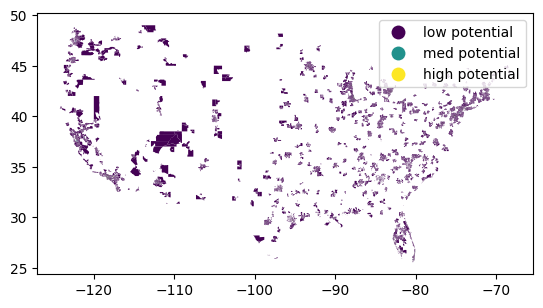

In [52]:
#Merge geometry attributes with normalized data
mcda_geodata = tract_geoid.merge(normalized_data, left_index=True, right_index=True)

#Map potential based on solar potential and energy burden
mcda_geodata.plot("potential", legend=True, cmap='viridis')